# Green Inventions - BRIGHT - 2021

### Packages & settings

In [81]:
options(warn=-1)
library(readr)
library(ggplot2)
library(ggrepel)
library(dplyr)
library(ggthemes)
library(ggtext)
library(grid)
library(ggraph)
library(igraph)
library(graphlayouts)
library(patchwork)
library("rnaturalearth")
library("rnaturalearthdata")
library("sf")
library("rgeos")
library(ggpubr)

### Map

Parsed with column specification:
cols(
  COU = col_character(),
  Country = col_character(),
  TYPE = col_character(),
  Type = col_character(),
  VAR = col_character(),
  Variable = col_character(),
  DOM = col_character(),
  `Technology domain` = col_character(),
  YEA = col_double(),
  Year = col_double(),
  Value = col_double(),
  `Flag Codes` = col_logical(),
  Flags = col_logical()
)



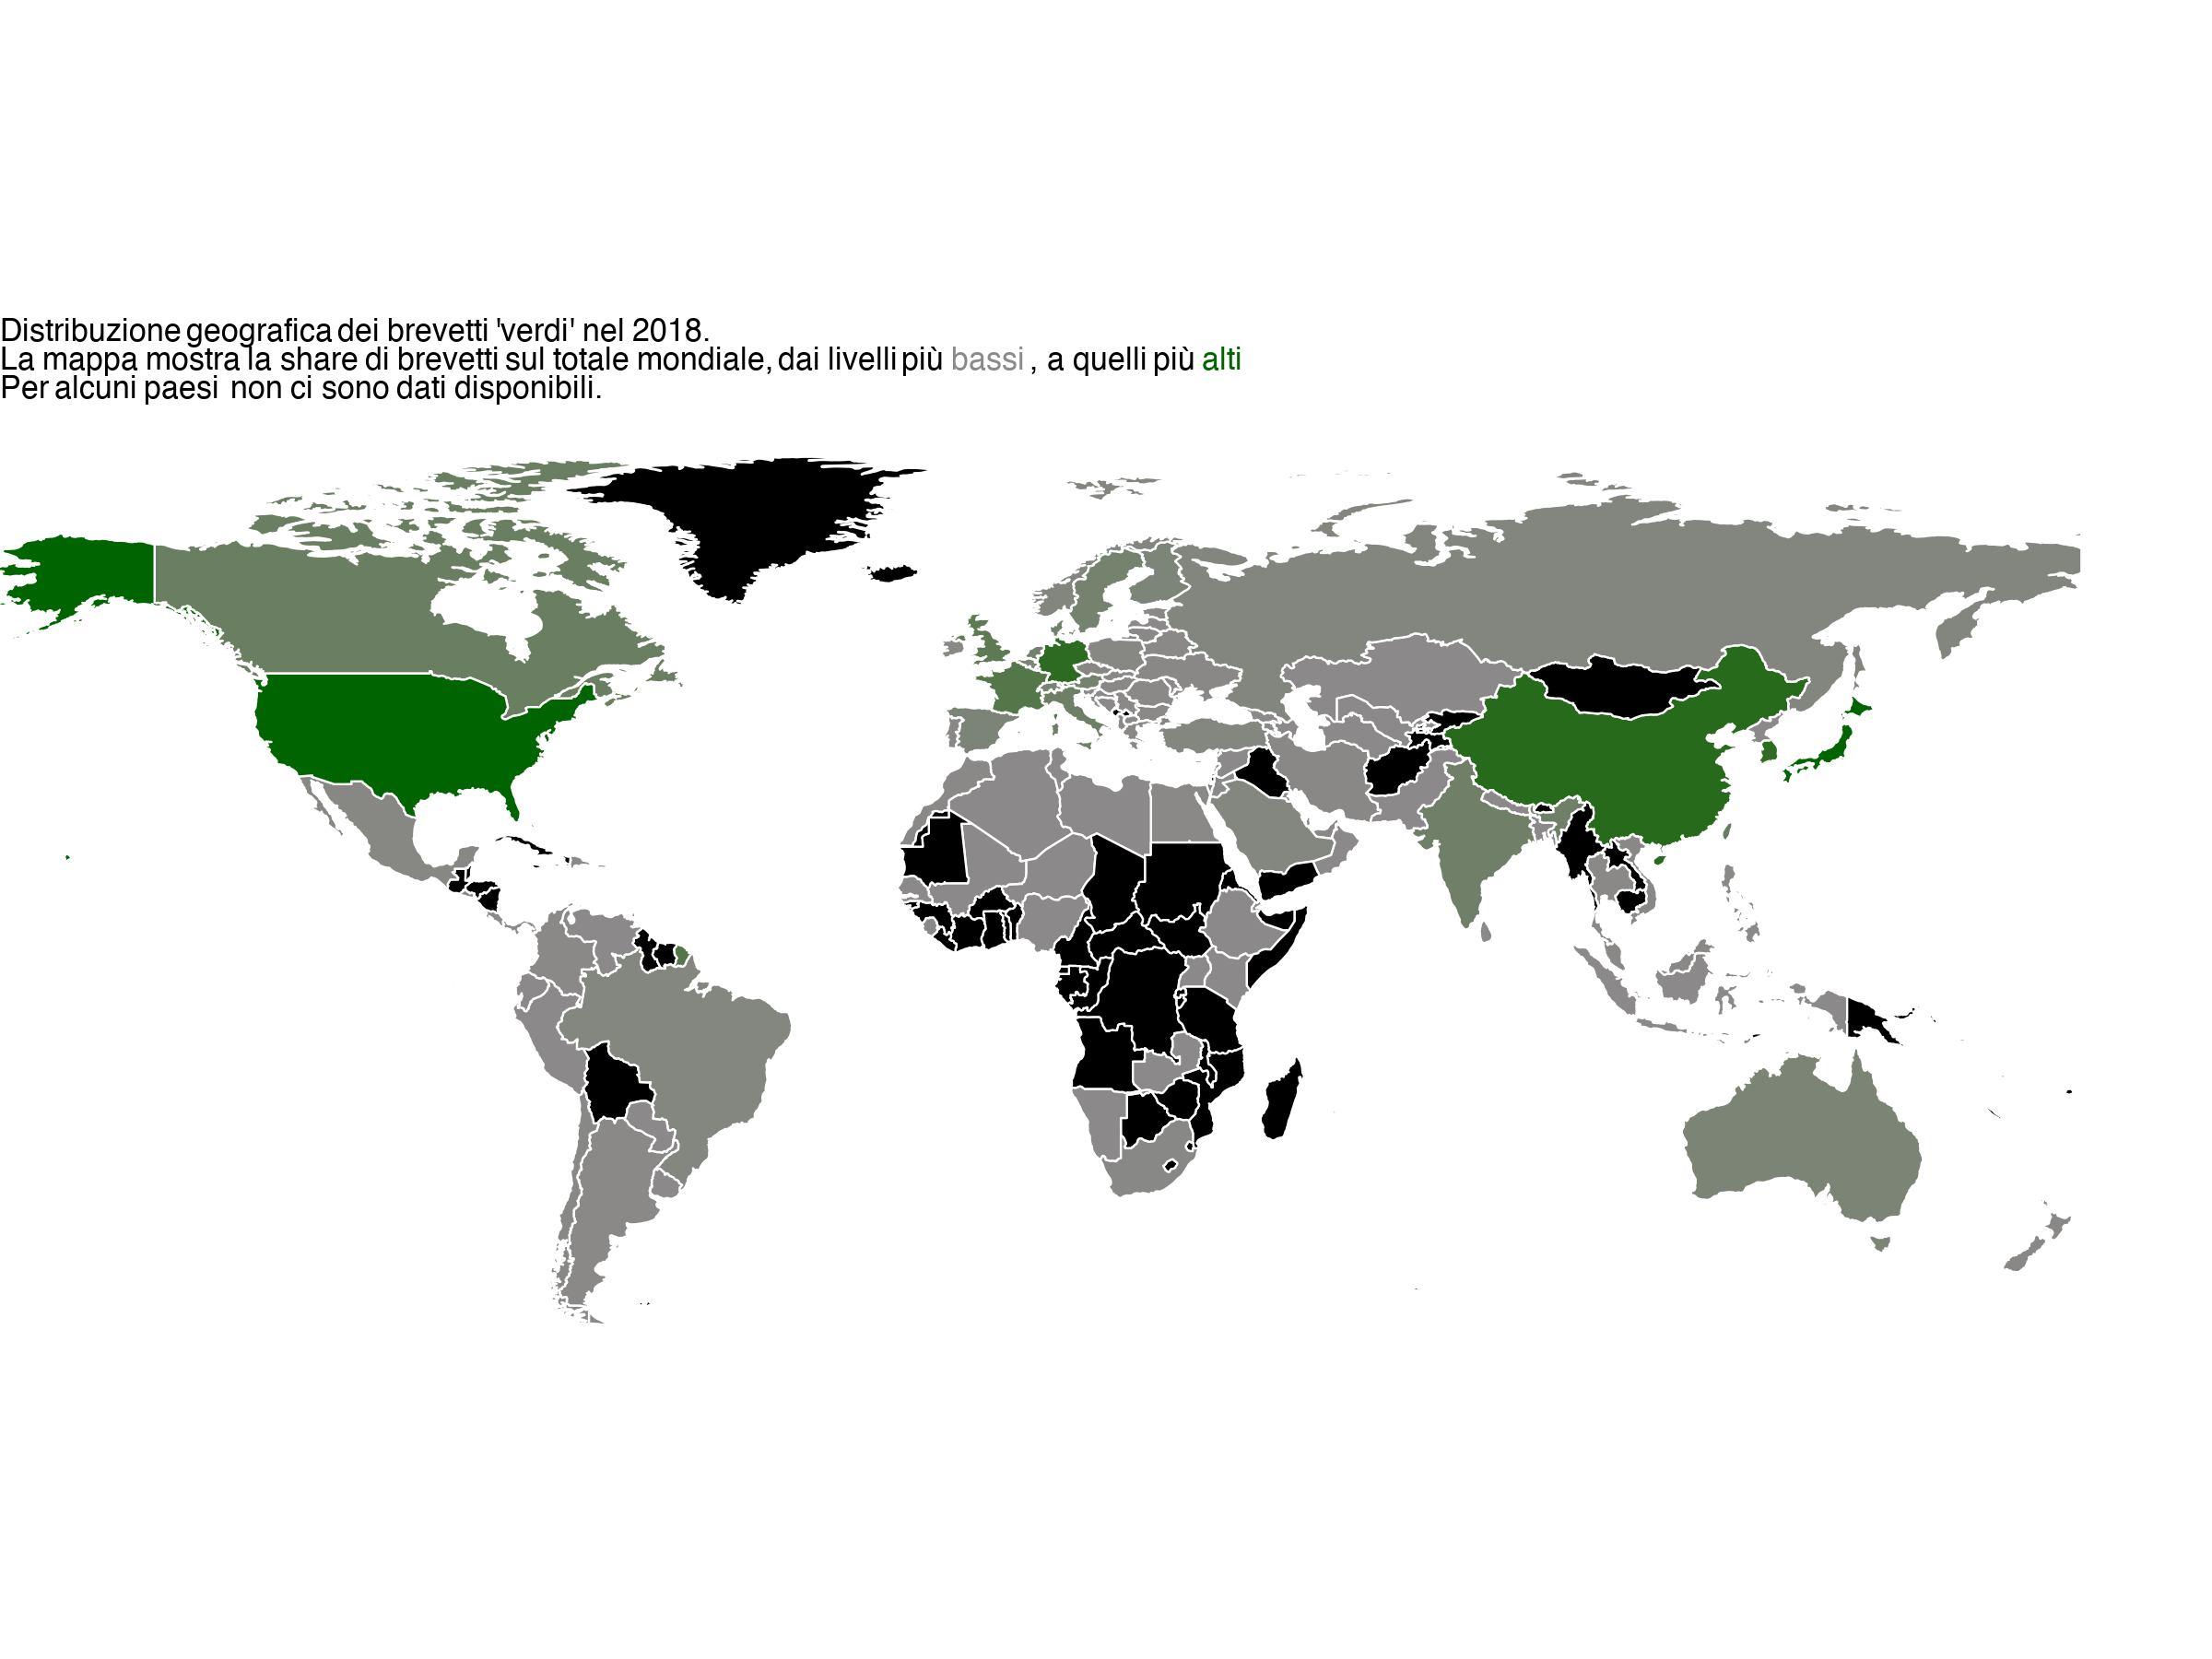

In [102]:
PAT_IND_29072021123349665 <- read_csv("~/Google Drive (giorgio.tripodi@sns.it)/climate_citations/bright/PAT_IND_29072021123349665.csv")
#str(PAT_IND_29072021123349665)

pat_map <- subset(PAT_IND_29072021123349665, TYPE=="DEV" & Variable=="Percentage of inventions worldwide" & `Technology domain`=="Environment-related technologies")
pat_map_filter <- subset(pat_map, Country!= "OECD - Europe" & Country!= "OECD Asia Oceania" & Country!= "OECD Asia Oceania"& Country!= "OECD America"& Country!= "World"& Country!= "OECD - Total" & Country!= "Euro area (19 countries)" & Country!="BRIICS economies - Brazil, Russia, India, Indonesia, China and South Africa")
pat_map_filter <- pat_map_filter %>% mutate(label = if_else(Year == max(Year), as.character(Country), NA_character_))

world <- ne_countries(scale = "medium", returnclass = "sf")

pat_map_filter_2018 <- subset(pat_map_filter,Year==2018)
names(pat_map_filter_2018)[names(pat_map_filter_2018) == "COU"] <- "iso_a3"
chore <- left_join(world, pat_map_filter_2018, by = "iso_a3")

na.value.forplot <- 'black'
a <- ggplot(data = chore) +
  geom_sf(aes(fill = Value, color=""), size=0.5) + lims(x = c(-150, 185), y = c(-52, 85)) + 
  scale_fill_gradient(low = "snow4", high = "darkgreen", na.value = na.value.forplot,trans="log1p") +
  scale_color_manual(values = 'white', labels = '') +
  guides(color = guide_legend(title="No Data",override.aes = list(fill = na.value.forplot))) +
  theme_void() + theme(legend.position = "left",  plot.title = element_markdown()) + guides(fill = "none", color="none") + 
  labs(title = " <span style='font-size:20pt'> Distribuzione geografica dei brevetti 'verdi' nel 2018. <br> 
    La mappa mostra la share di brevetti sul totale mondiale, dai livelli più 
    <span style='color:snow4;'>**bassi**</span>, a quelli più
    <span style='color:darkgreen;'>**alti**</span> <br> 
    Per alcuni **paesi** non ci sono dati disponibili. 
    </span>")
options(repr.plot.width=20, repr.plot.height=15)
a 

### Trend

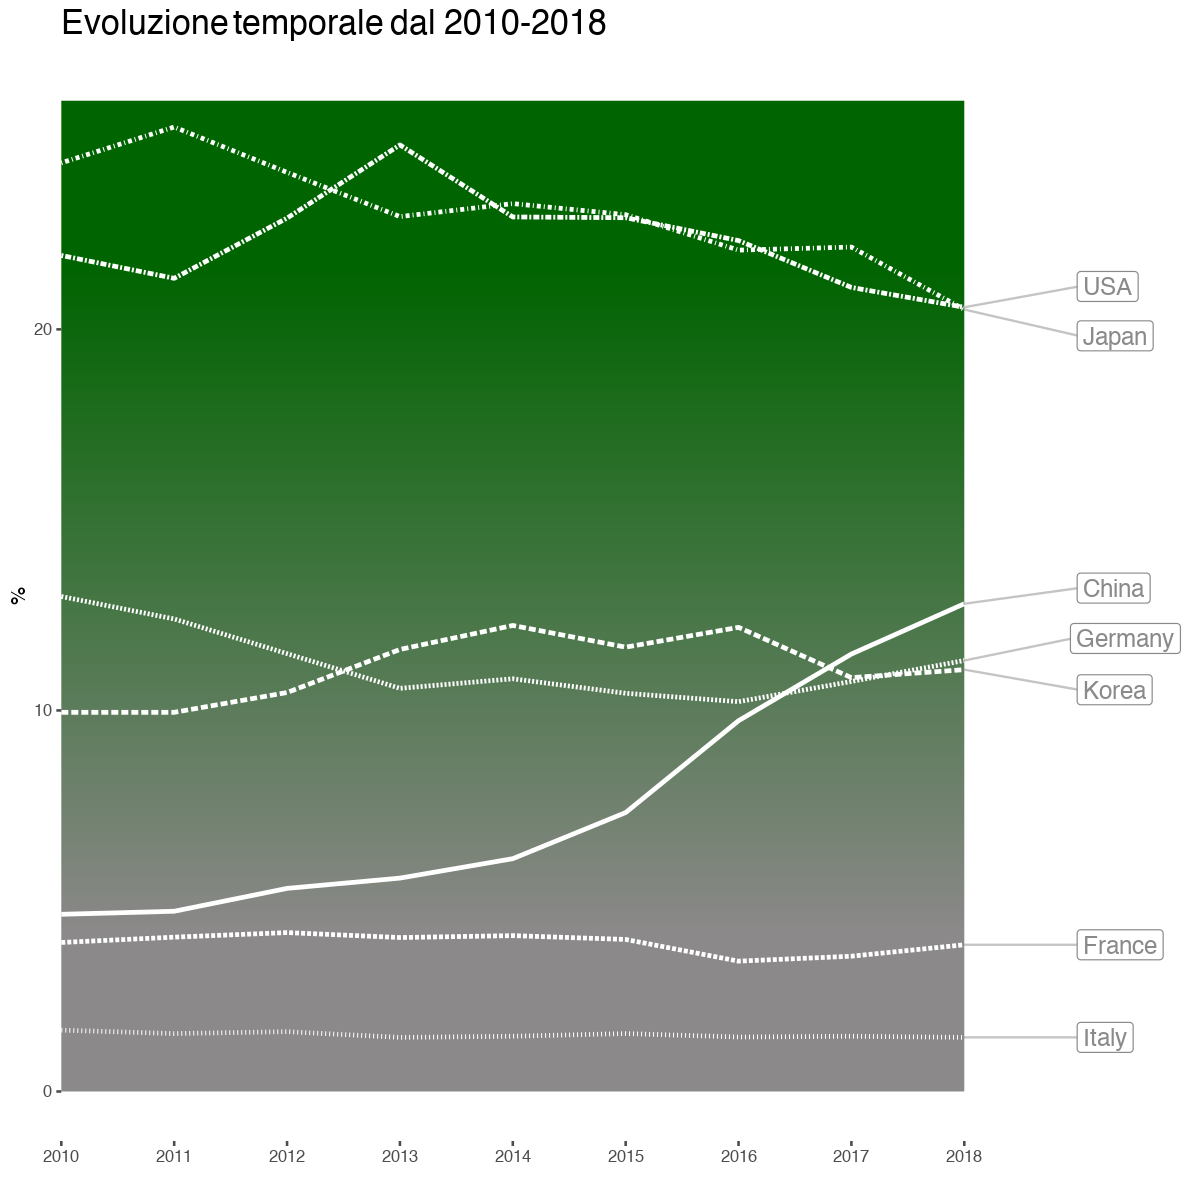

In [103]:
datab=subset(pat_map_filter,Value>3 |Country=="Italy")
datab$label <- as.factor(datab$label)
levels(datab$label)[levels(datab$label)=="United States"] <- "USA"
levels(datab$label)[levels(datab$label)=="China (People's Republic of)"] <- "China"

#col <- c("darkgreen", "snow4")
col <- colorRampPalette(c("darkgreen", "snow4"))(3)
g <- rasterGrob(col, width = unit(1, "npc"), height = unit(1, "npc"),   
                interpolate = T) 

b <- ggplot(data=datab,aes(x=Year, y=Value, linetype=factor(COU)))+ 
  annotation_custom(g, xmin=2010, xmax=2018, ymin=0, ymax=26) +
  theme_few() +
  coord_cartesian(clip = "off",ylim = c(0, 26))  + 
  scale_x_continuous(expand = c(0, 0),limits = c(2010, 2020), breaks = seq(2010, 2018, by = 1)) + 
  theme(panel.border = element_blank()) + 
  labs(title = "<span style='font-size:20pt'> Evoluzione temporale  dal 2010-2018</span>")  +
  geom_line(size=1, color="white") + 
  #geom_point(size=5, color="white") + 
  geom_label_repel(aes(label = label),nudge_x = 1,color="snow4",
                   fontface = "bold",
                   size = 5,
                   direction = "y",
                   xlim = c(2018, NA),
                   hjust = 0,
                   segment.size = .5,
                   segment.alpha = .5,
                   box.padding = .4) + 
  theme(legend.position = "none", plot.title = element_markdown()) +
  ylab("%") + xlab("") + scale_fill_brewer(palette="Greens") + scale_color_brewer(palette="Greens") 
options(repr.plot.width=10, repr.plot.height=10)
b  

### Network

Parsed with column specification:
cols(
  PAR1 = col_character(),
  Country = col_character(),
  PAR2 = col_character(),
  Partner = col_character(),
  DOM = col_character(),
  `Techology domain` = col_character(),
  YEA = col_double(),
  Year = col_double(),
  `Unit Code` = col_character(),
  Unit = col_character(),
  `PowerCode Code` = col_double(),
  PowerCode = col_character(),
  `Reference Period Code` = col_logical(),
  `Reference Period` = col_logical(),
  Value = col_double(),
  `Flag Codes` = col_logical(),
  Flags = col_logical()
)



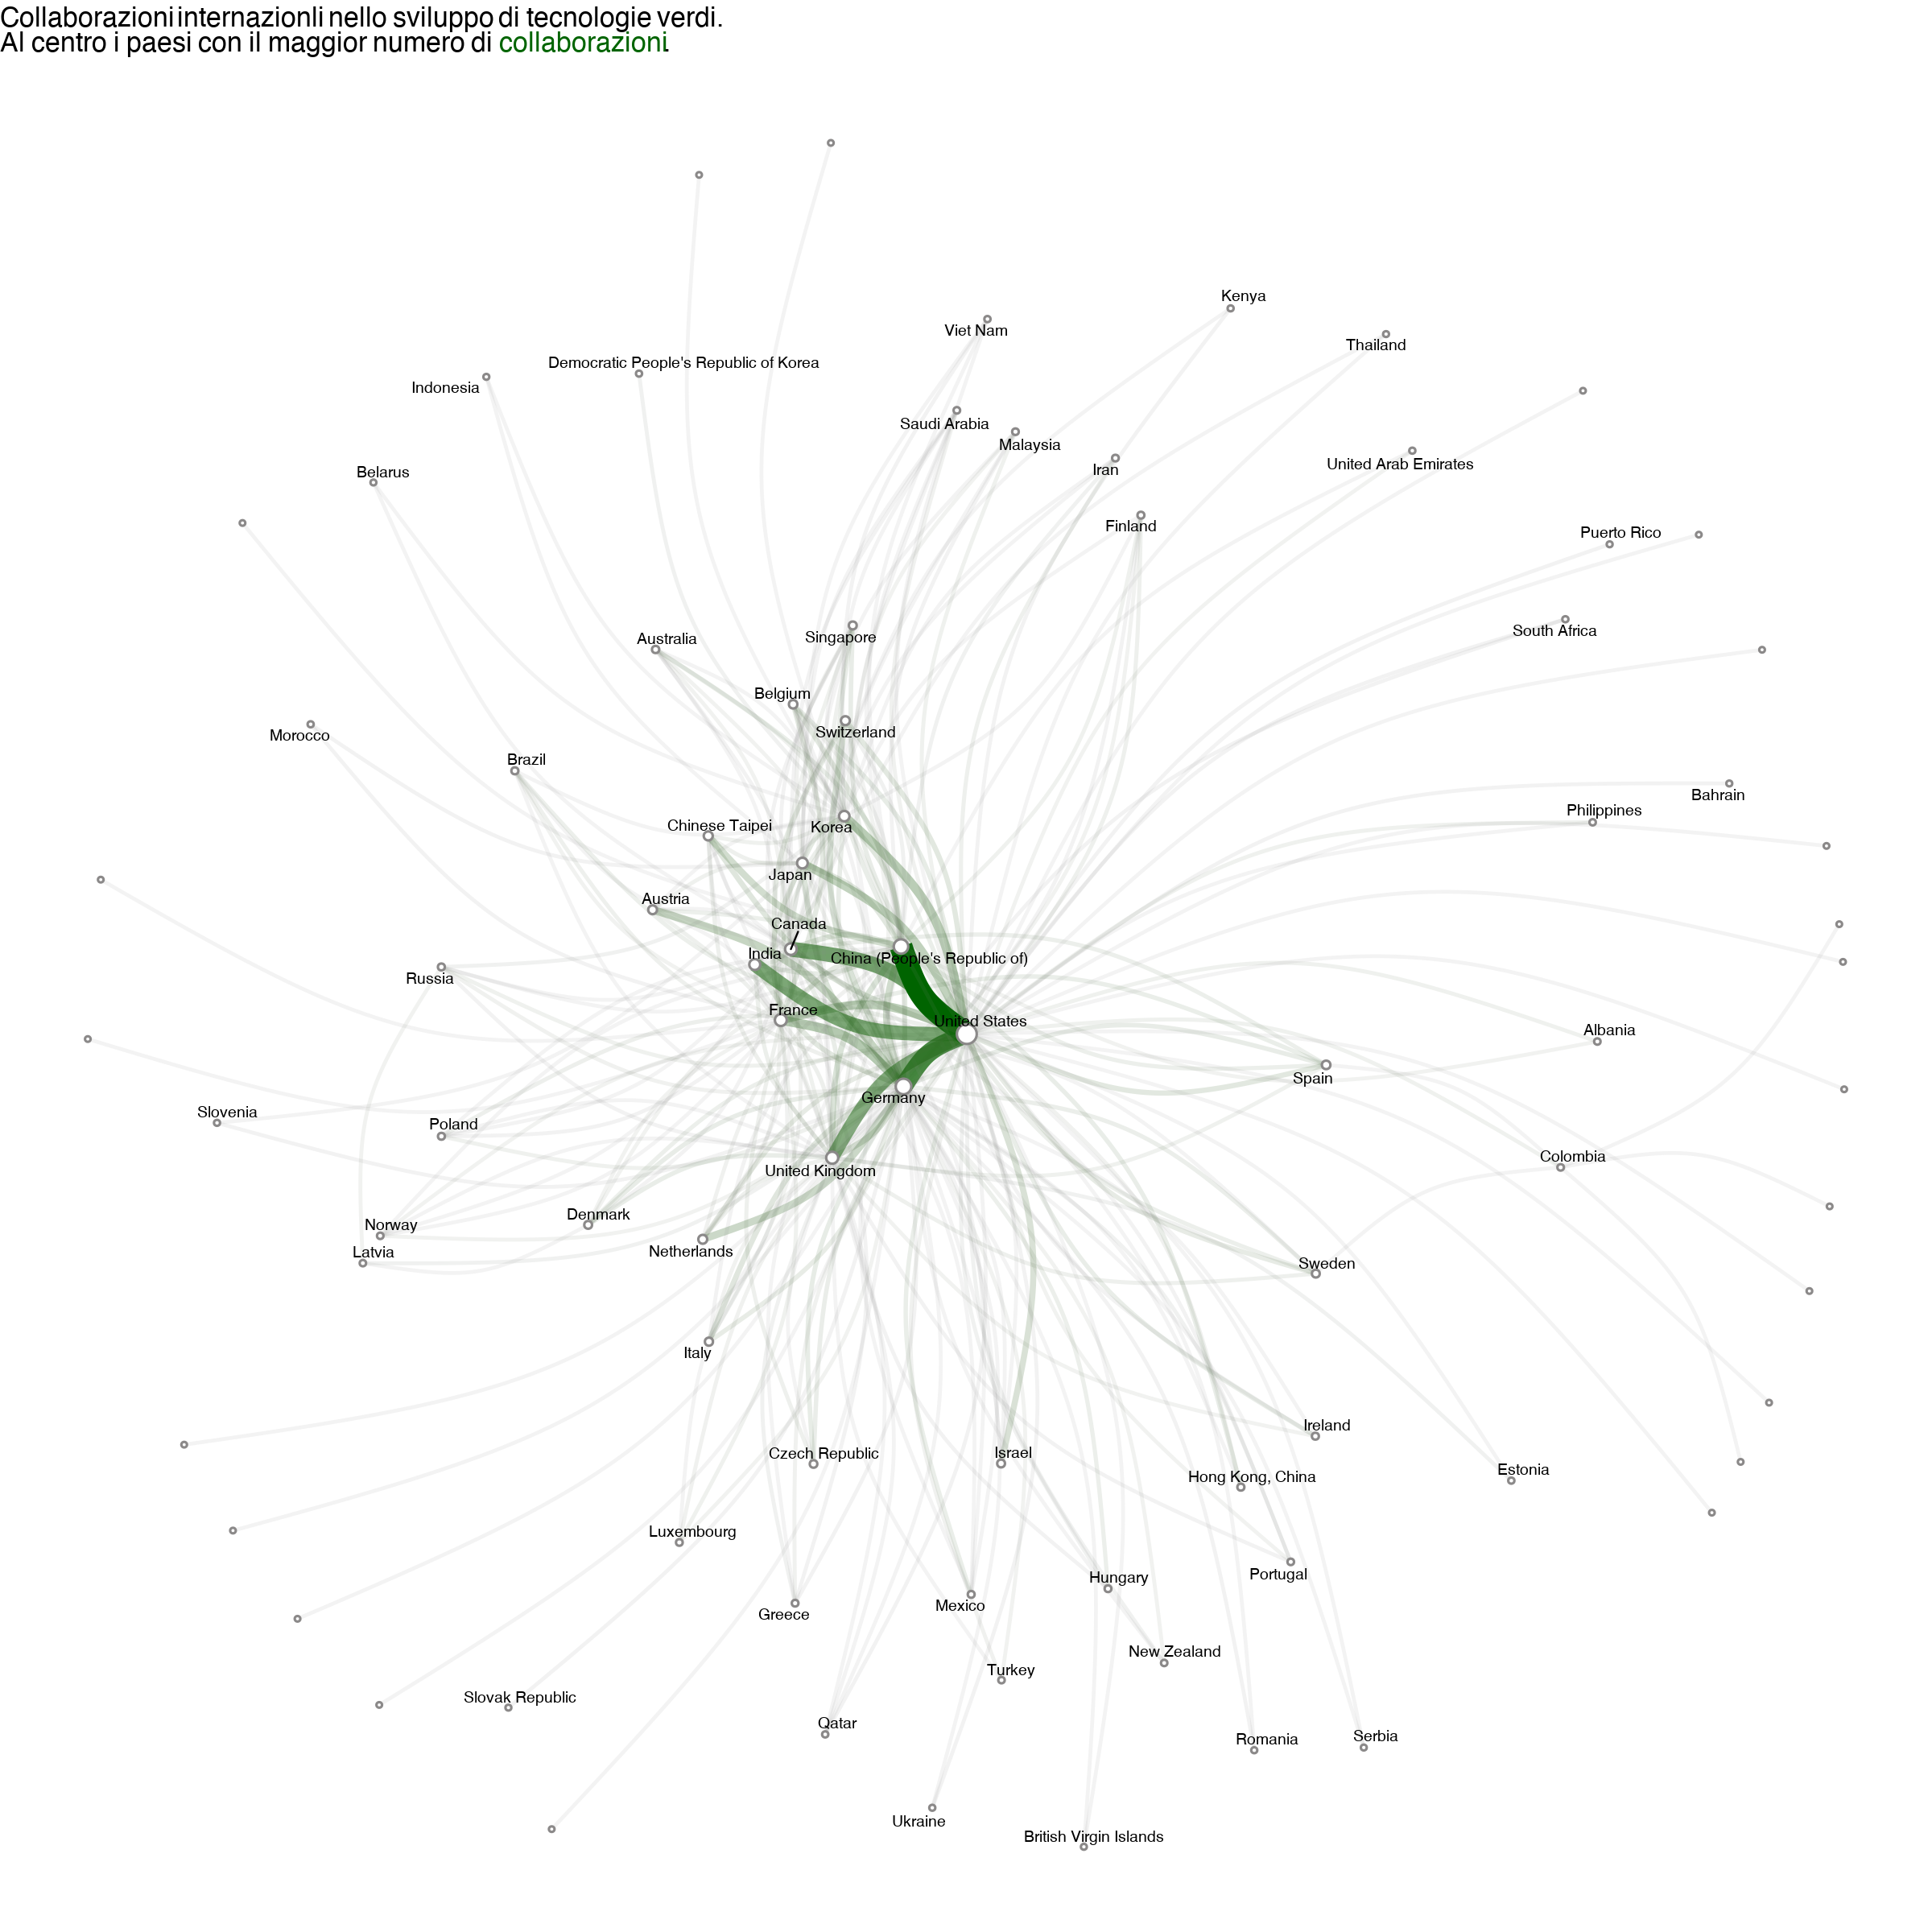

In [105]:
PAT_COL_05082021180158296 <- read_csv("~/Google Drive (giorgio.tripodi@sns.it)/climate_citations/bright/PAT_COL_05082021180158296.csv")
net <- subset(PAT_COL_05082021180158296, Year==2018 & `Techology domain`=="Environment-related technologies")
net <- dplyr::select(net,c("Country","Partner", "Value"))
names(net)[names(net) == "Value"] <- "weight"

graph <- graph_from_data_frame(net, directed = F)
graph <- simplify(graph)

c <- ggraph(graph, layout = "centrality",cent = log(graph.strength(graph))) +
  #draw_circle(col="black",use = "cent") +
  geom_edge_arc(aes(edge_width=weight, edge_color=weight, edge_alpha=weight), strength=0.2)+  
  geom_node_point(aes(size = strength(graph)),shape=21,fill="white",alpha=1,color="snow4",stroke=1) +
  theme_void() +
  theme(legend.position = "none", plot.title = element_markdown()) + scale_edge_color_gradient(low = "snow4", high = "darkgreen",na.value = na.value.forplot,trans="log1p")+
  geom_node_text(aes(label=ifelse(strength(graph) > 1, name, NA)), color="black", repel=T, size=4) +
  labs(title = "  <span style='font-size:20pt'> Collaborazioni internazionli nello sviluppo di tecnologie verdi. <br>
  Al centro i paesi con il maggior numero di
    <span style='color:darkgreen;'>collaborazioni</span>.
    </span>")
options(repr.plot.width=20, repr.plot.height=20)
c 

### Patchwork

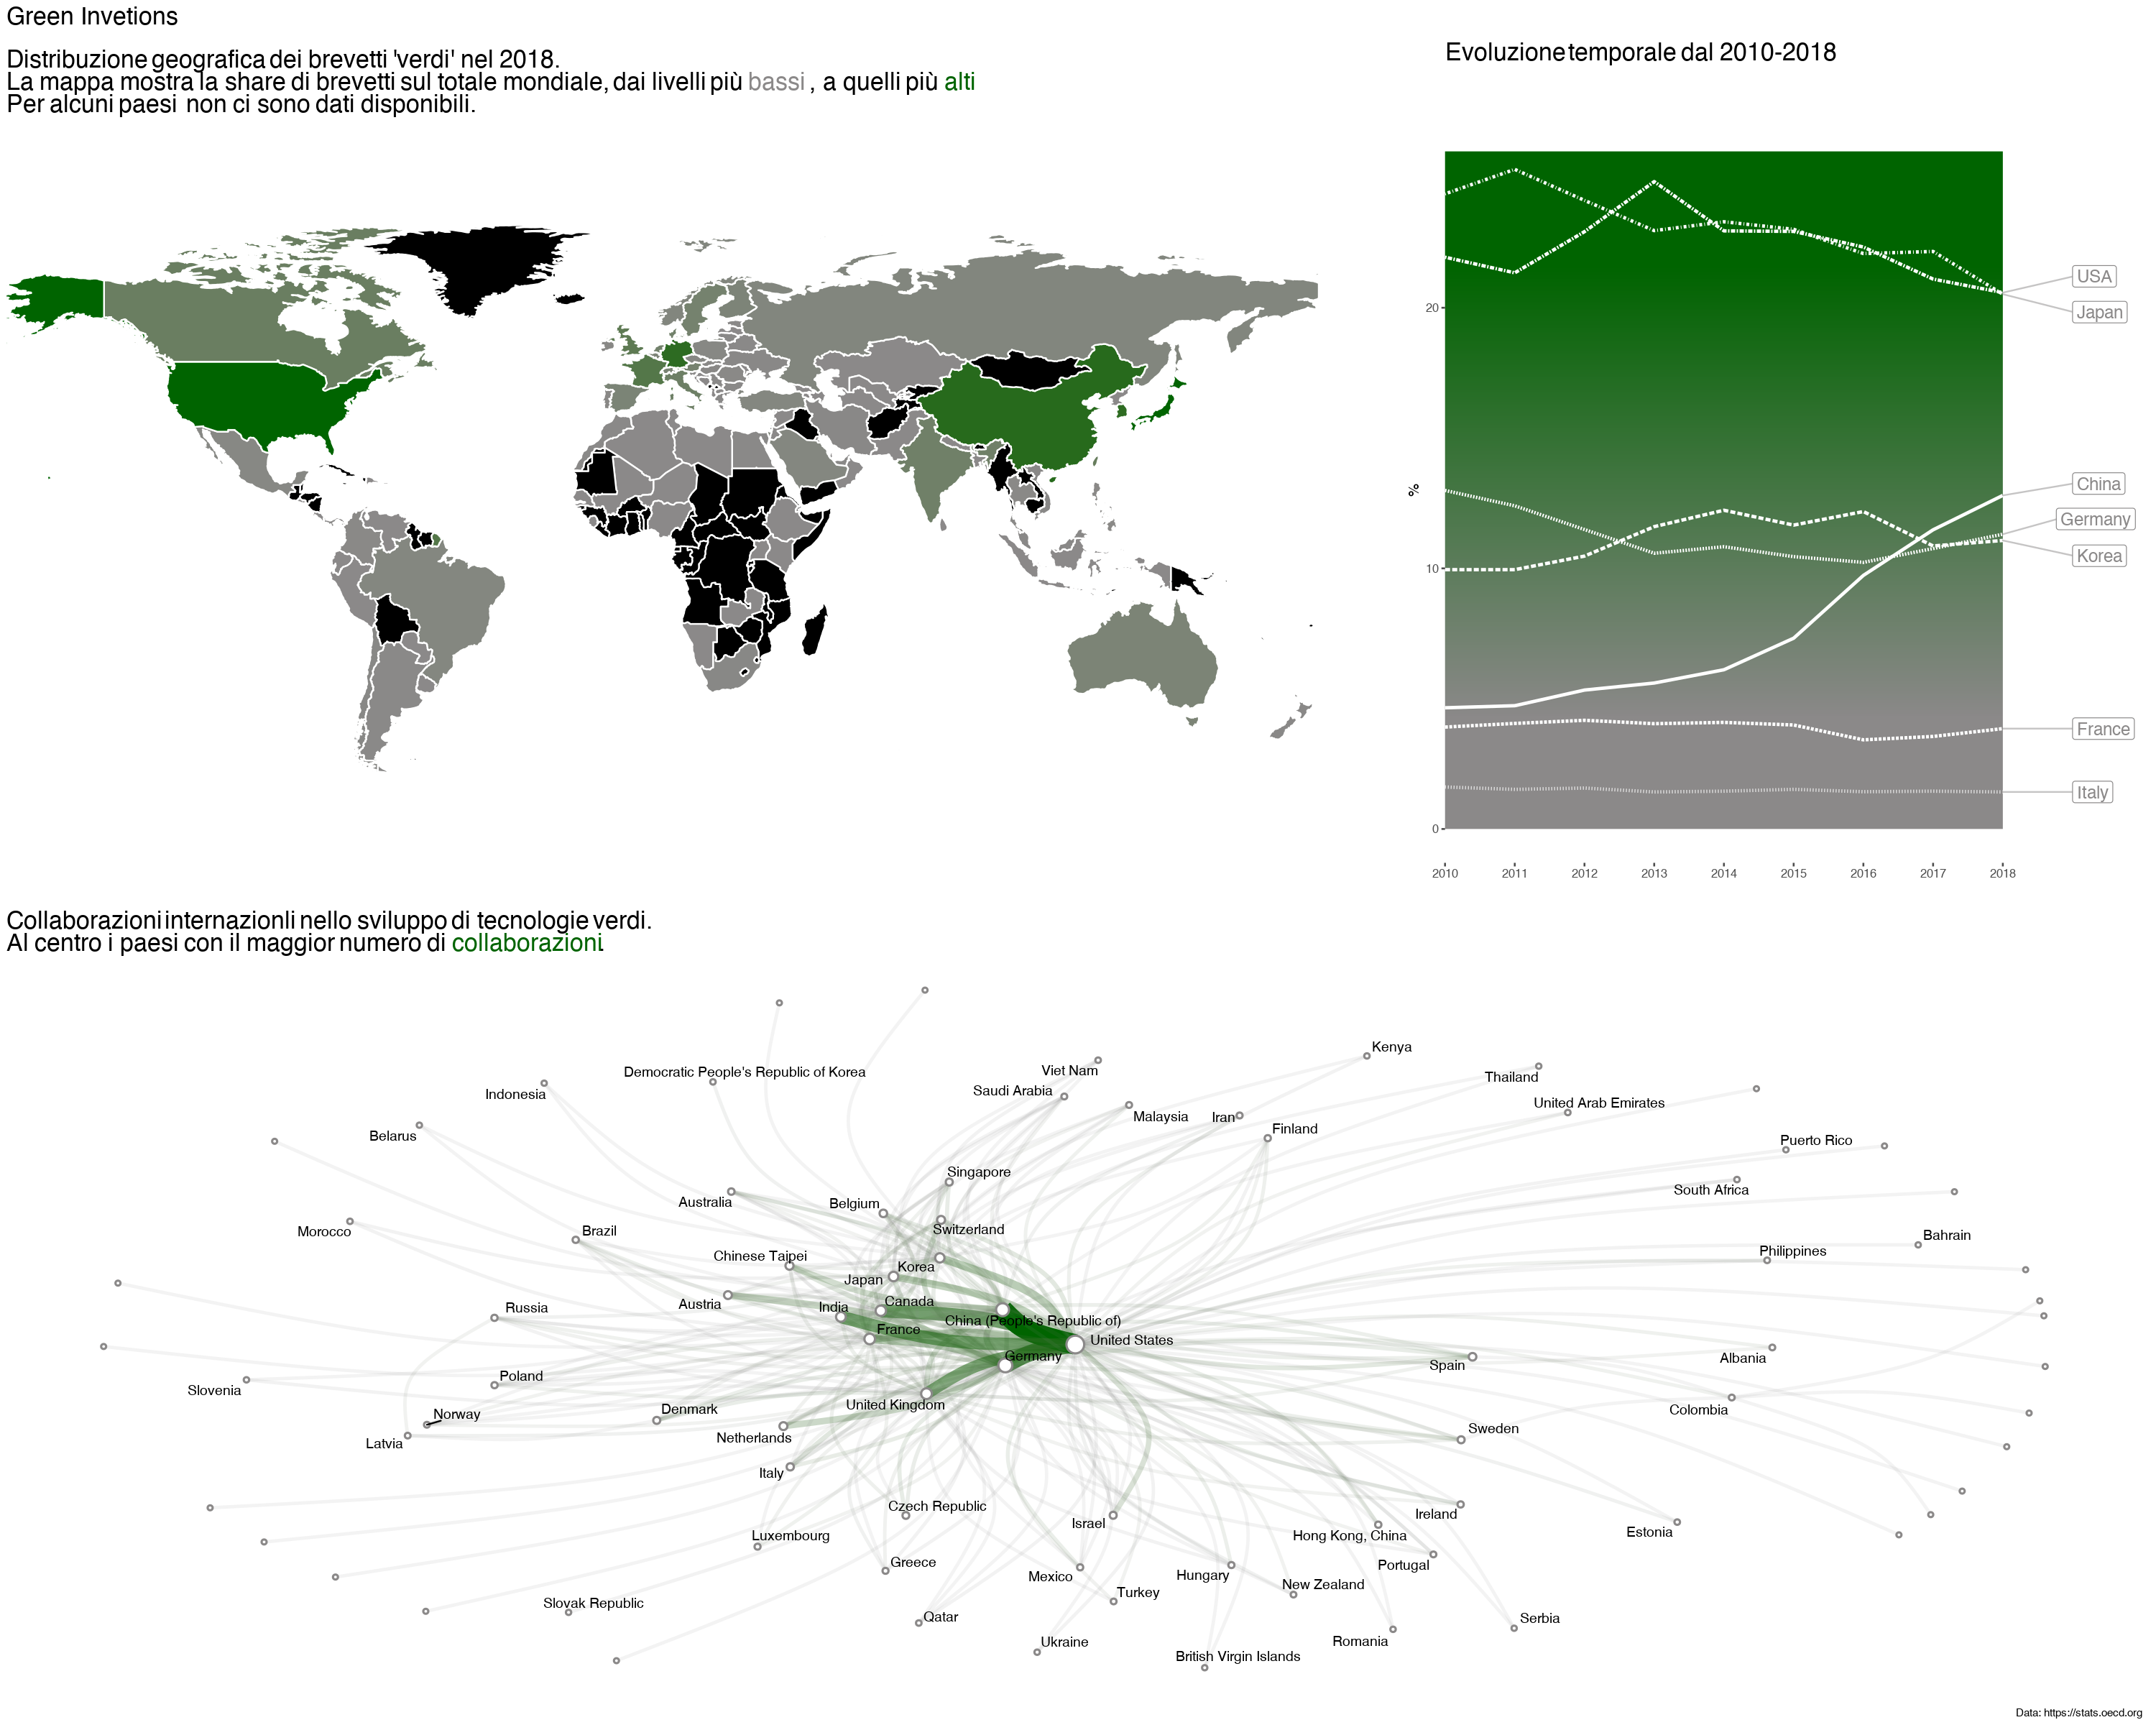

In [107]:

aa <- (a | b) + plot_layout(widths = c(2, 1))
final <- aa /c

options(repr.plot.width=25, repr.plot.height=20)

final + plot_annotation(title = "Green Invetions",
                caption = "Data: https://stats.oecd.org",
                theme = theme(plot.title = element_text(size = 20, face = "bold")))
